In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import palettable
import pickle
from NODE_fns import NODE_sigma_vmap
import pandas as pd

### 1. Prepare porcine data

In [2]:
with open('training_data/' + 'P12AC1_xybsxsy.npy', 'rb') as f:
    lamb, sigma_gt = np.load(f,allow_pickle=True)

In [3]:
labels = ['lambda_x', 'lambda_y', 'sigma_xx [MPa]', 'sigma_yy [MPa]']
df = pd.DataFrame(np.hstack([lamb,sigma_gt]), columns = labels)
df

,lambda_x,lambda_y,sigma_xx [MPa],sigma_yy [MPa]
0,1.000000,1.000000,-0.000460,0.000278
1,1.001110,1.001934,0.002305,0.000278
2,1.002221,1.004006,0.000461,0.000279
3,1.003331,1.006354,-0.000462,0.000279
4,1.004442,1.008565,0.002313,0.001213
...,...,...,...,...
397,1.000000,1.143536,0.114521,0.498951
398,1.000000,1.145980,0.118142,0.528961
399,1.000000,1.148289,0.123574,0.556979
400,1.000000,1.150190,0.131631,0.587875


In [4]:
df.to_csv('training_data/NODE_porcine_skin_data_1.csv')

In [5]:
with open('training_data/' + 'P12BC2_xyb.npy', 'rb') as f:
    lamb1, sigma_gt1 = np.load(f,allow_pickle=True)
with open('training_data/' + 'P12BC2_sxsy.npy', 'rb') as f:
    lamb2, sigma_gt2 = np.load(f,allow_pickle=True)

lamb = np.vstack([lamb1,lamb2])
sigma_gt = np.vstack([sigma_gt1, sigma_gt2])

In [6]:
labels = ['lambda_x', 'lambda_y', 'sigma_xx [MPa]', 'sigma_yy [MPa]']
df = pd.DataFrame(np.hstack([lamb,sigma_gt]), columns = labels)
df

,lambda_x,lambda_y,sigma_xx [MPa],sigma_yy [MPa]
0,1.000000,1.000000,0.001257,0.001971
1,1.001028,1.001760,0.002097,0.001116
2,1.002185,1.004023,0.000420,0.000258
3,1.003213,1.006285,0.002102,0.001121
4,1.004370,1.008422,-0.000421,0.000259
...,...,...,...,...
427,1.000000,1.171613,0.078489,0.472099
428,1.000000,1.173559,0.085705,0.496532
429,1.000000,1.175748,0.088948,0.518214
430,1.000000,1.178180,0.092921,0.548032


In [7]:
df.to_csv('training_data/NODE_porcine_skin_data_2.csv')

# 2. Prepare the rubber data for training

### First Piola-Kirchhoff stress

In [12]:
ex = pd.read_excel('training_data/CANNSdata.xlsx')
rubber20UT_F11 = np.array(ex.iloc[4:29,0], dtype='float')
rubber20UT_P11 = np.array(ex.iloc[4:29,2], dtype='float')

rubber20ET_F11 = np.array(ex.iloc[4:21,3], dtype='float')
rubber20ET_P11 = np.array(ex.iloc[4:21,5], dtype='float')

rubber20PS_F11 = np.array(ex.iloc[4:18,6], dtype='float')
rubber20PS_P11 = np.array(ex.iloc[4:18,8], dtype='float')*10 #there is a mistake in the excel

rubber50UT_F11 = np.array(ex.iloc[4:19,10], dtype='float')
rubber50UT_P11 = np.array(ex.iloc[4:19,12], dtype='float')

rubber50ET_F11 = np.array(ex.iloc[4:24,13], dtype='float')
rubber50ET_P11 = np.array(ex.iloc[4:24,15], dtype='float')

rubber50PS_F11 = np.array(ex.iloc[4:22,16], dtype='float')
rubber50PS_P11 = np.array(ex.iloc[4:22,18], dtype='float')


[Text(0, 0.5, '$P_{11}$')]

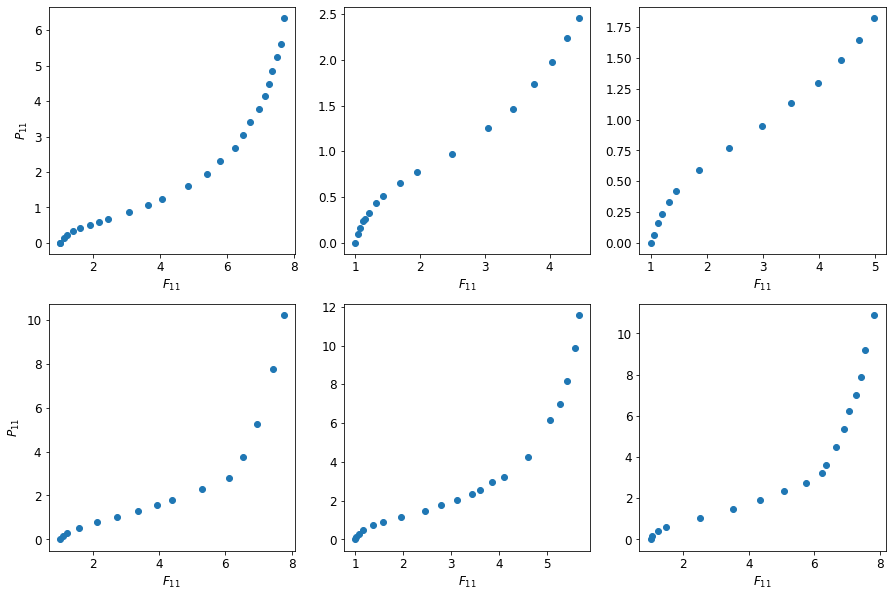

In [13]:
row1x = [rubber20UT_F11, rubber20ET_F11, rubber20PS_F11]
row1y = [rubber20UT_P11, rubber20ET_P11, rubber20PS_P11]
row2x = [rubber50UT_F11, rubber50ET_F11, rubber50PS_F11]
row2y = [rubber50UT_P11, rubber50ET_P11, rubber50PS_P11]
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,3,figsize=(15,10))
for x,y,axi in zip(row1x, row1y, ax[0,:]):
    axi.plot(x,y, 'o')
    axi.set(xlabel='$F_{11}$')
for x,y,axi in zip(row2x, row2y, ax[1,:]):
    axi.plot(x,y, 'o')
    axi.set(xlabel='$F_{11}$')

ax[0,0].set(ylabel='$P_{11}$')
ax[1,0].set(ylabel='$P_{11}$')

### Cauchy stress

In [14]:
# Uniaxial Tension (UT)
# lm2 = lm3 = 1/sqrt(lm1)
# sigma_22 = sigma_33 = 0
rubber20UT_lmb = np.array([rubber20UT_F11, 1/np.sqrt(rubber20UT_F11)])
rubber20UT_sgm = np.array([rubber20UT_P11*rubber20UT_F11, np.zeros_like(rubber20UT_P11)])

rubber50UT_lmb = np.array([rubber50UT_F11, 1/np.sqrt(rubber50UT_F11)])
rubber50UT_sgm = np.array([rubber50UT_P11*rubber50UT_F11, np.zeros_like(rubber50UT_P11)])

# Equibiaxial tension (ET)
# lm1 = lm2, lm3 = 1/(lm1*lm2)
# sigma_22 = sigma_11, sigma_33 = 0
rubber20ET_lmb = np.array([rubber20ET_F11, rubber20ET_F11]) 
rubber20ET_sgm = np.array([rubber20ET_P11*rubber20ET_F11, rubber20ET_P11*rubber20ET_F11]) 

rubber50ET_lmb = np.array([rubber50ET_F11, rubber50ET_F11])
rubber50ET_sgm = np.array([rubber50ET_P11*rubber50ET_F11, rubber50ET_P11*rubber50ET_F11])

# Pure Shear/Strip biaxial
# lm2 = 1, lm3 = 1/lm1
# We don't know sigma_22 so we will have to change the train fn
rubber20PS_lmb = np.array([rubber20PS_F11, np.ones_like(rubber20PS_F11)]) 
rubber20PS_sgm = np.array([rubber20PS_P11*rubber20PS_F11, np.zeros_like(rubber20PS_P11)])

rubber50PS_lmb = np.array([rubber50PS_F11, np.ones_like(rubber50PS_F11)])
rubber50PS_sgm = np.array([rubber50PS_P11*rubber50PS_F11, np.zeros_like(rubber50PS_P11)])

rubber20_lmb = np.hstack([rubber20UT_lmb, rubber20ET_lmb, rubber20PS_lmb]).T
rubber20_sgm = np.hstack([rubber20UT_sgm, rubber20ET_sgm, rubber20PS_sgm]).T
rubber50_lmb = np.hstack([rubber50UT_lmb, rubber50ET_lmb, rubber50PS_lmb]).T
rubber50_sgm = np.hstack([rubber50UT_sgm, rubber50ET_sgm, rubber50PS_sgm]).T

with open('training_data/rubber20UT_ET_PS.npy', 'wb') as f:
    np.save(f,[rubber20_lmb,rubber20_sgm], allow_pickle=True)

with open('training_data/rubber50UT_ET_PS.npy', 'wb') as f:
    np.save(f,[rubber50_lmb,rubber50_sgm], allow_pickle=True)

n_UT = 25
n_ET = 17
n_PS = 14
i_UT = n_UT
i_ET = i_UT + n_ET
i_PS = i_ET + n_PS
with open('training_data/rubber20UT.npy', 'wb') as f:
    np.save(f,[rubber20_lmb[:i_UT],rubber20_sgm[:i_UT]], allow_pickle=True)
with open('training_data/rubber20ET.npy', 'wb') as f:
    np.save(f,[rubber20_lmb[i_UT:i_ET],rubber20_sgm[i_UT:i_ET]], allow_pickle=True)
with open('training_data/rubber20PS.npy', 'wb') as f:
    np.save(f,[rubber20_lmb[i_ET:i_PS],rubber20_sgm[i_ET:i_PS]], allow_pickle=True)
with open('training_data/rubber20UT_ET.npy', 'wb') as f:
    np.save(f,[rubber20_lmb[:i_ET],rubber20_sgm[:i_ET]], allow_pickle=True)

[Text(0, 0.5, '$\\sigma_{11}$')]

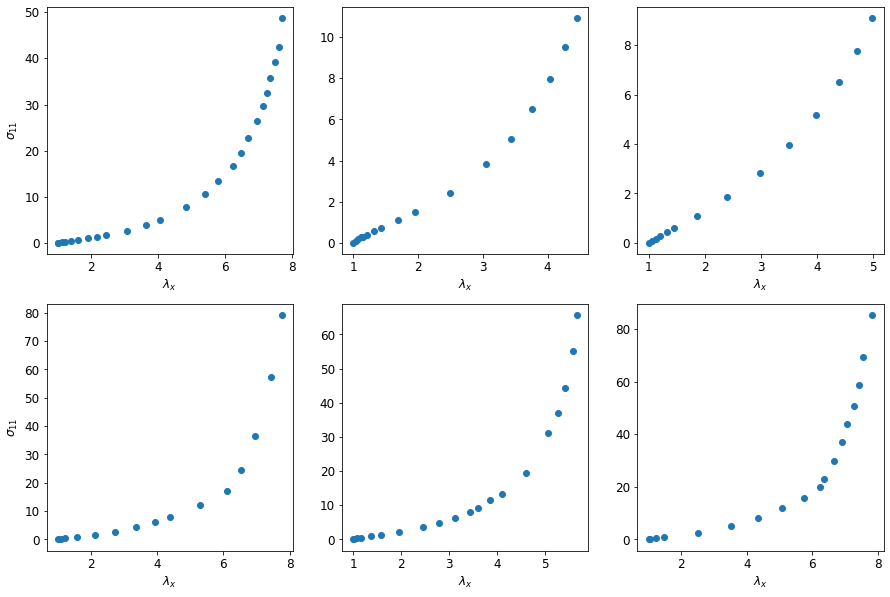

In [5]:
row1x = [rubber20UT_lmb[0,:], rubber20ET_lmb[0,:], rubber20PS_lmb[0,:]]
row1y = [rubber20UT_sgm[0,:], rubber20ET_sgm[0,:], rubber20PS_sgm[0,:]]
row2x = [rubber50UT_lmb[0,:], rubber50ET_lmb[0,:], rubber50PS_lmb[0,:]]
row2y = [rubber50UT_sgm[0,:], rubber50ET_sgm[0,:], rubber50PS_sgm[0,:]]
fig, ax = plt.subplots(2,3,figsize=(15,10))
for x,y,axi in zip(row1x, row1y, ax[0,:]):
    axi.plot(x,y, 'o')
    axi.set(xlabel='$\lambda_x$')
for x,y,axi in zip(row2x, row2y, ax[1,:]):
    axi.plot(x,y, 'o')
    axi.set(xlabel='$\lambda_x$')

ax[0,0].set(ylabel='$\sigma_{11}$')
ax[1,0].set(ylabel='$\sigma_{11}$')


### Second Piola Kirchhoff stress

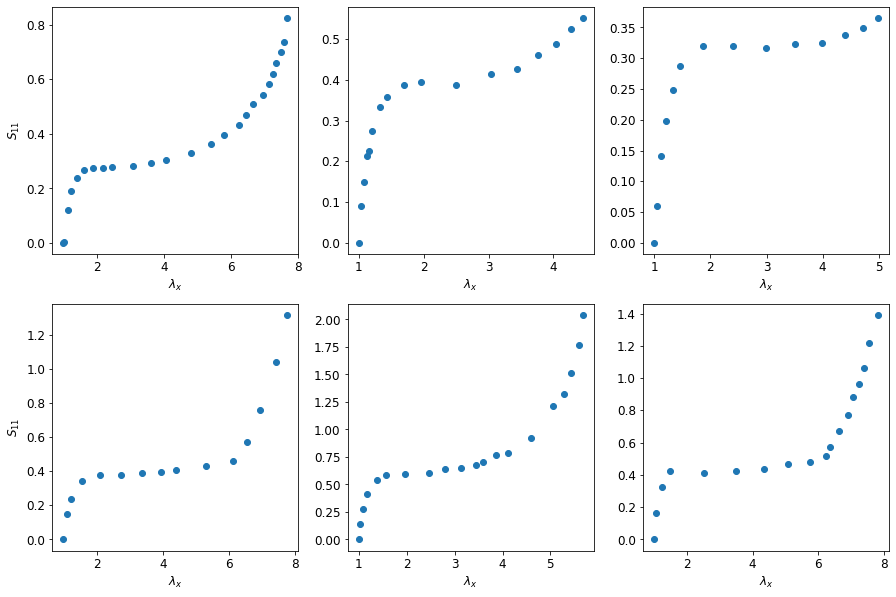

In [6]:
rubber20UT_S11 = rubber20UT_P11/rubber20UT_F11
rubber20ET_S11 = rubber20ET_P11/rubber20ET_F11
rubber20PS_S11 = rubber20PS_P11/rubber20PS_F11

rubber50UT_S11 = rubber50UT_P11/rubber50UT_F11
rubber50ET_S11 = rubber50ET_P11/rubber50ET_F11
rubber50PS_S11 = rubber50PS_P11/rubber50PS_F11

row1x = [rubber20UT_lmb[0,:], rubber20ET_lmb[0,:], rubber20PS_lmb[0,:]]
row1y = [rubber20UT_S11, rubber20ET_S11, rubber20PS_S11]
row2x = [rubber50UT_lmb[0,:], rubber50ET_lmb[0,:], rubber50PS_lmb[0,:]]
row2y = [rubber50UT_S11, rubber50ET_S11, rubber50PS_S11]

fig, ax = plt.subplots(2,3,figsize=(15,10))
for x,y,axi in zip(row1x, row1y, ax[0,:]):
    axi.plot(x,y, 'o')
    axi.set(xlabel='$\lambda_x$')
for x,y,axi in zip(row2x, row2y, ax[1,:]):
    axi.plot(x,y, 'o')
    axi.set(xlabel='$\lambda_x$')

ax[0,0].set(ylabel='$S_{11}$')
ax[1,0].set(ylabel='$S_{11}$'); 

### Check convexity (Monotonicity of S wrt C)

In [7]:
z = np.zeros_like(rubber20UT_F11)
rubber20UT_F = np.array([[rubber20UT_F11, z, z] ,[z, 1/np.sqrt(rubber20UT_F11), z], [z, z, 1/np.sqrt(rubber20UT_F11)]]).T
rubber20UT_C = np.einsum('pij,pkj->pik', rubber20UT_F, rubber20UT_F)
rubber20UT_S = np.array([[rubber20UT_S11, z, z] ,[z, z, z], [z, z, z]]).T

In [8]:
ndata = rubber20UT_F.shape[0]
global_convexity = np.zeros(ndata)
for i in range(ndata):
    for j in range(ndata):
        temp = np.einsum('ij,ij', rubber20UT_S[i]-rubber20UT_S[j], rubber20UT_C[i]-rubber20UT_C[j])
        global_convexity[i]+= np.min([0,temp])
global_convexity

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

### Ghent model fit

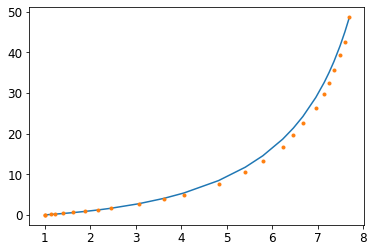

In [92]:
fig, ax = plt.subplots()
lmb = rubber20UT_lmb.T
mu = 0.27812
J = 85.2358
lm3 = 1/(lmb[:,0]*lmb[:,1])
z = np.zeros_like(lm3)
F = np.array([[lmb[:,0], z, z],
              [z, lmb[:,1], z],
              [z, z, lm3      ]]).T
C = np.einsum('pij,pjk->pik', F, F)
Cinv = np.linalg.inv(C)
I1 = lmb[:,0]**2 + lmb[:,1]**2 + lm3**2

c1 = mu/2*(J/(J-I1+3))
p = -2*c1*C[:,2,2]
S = np.zeros_like(C)
for i in range(S.shape[0]):
    S[i] = 2*c1[i]*(np.eye(3) - C[i,2,2]*Cinv[i])

# S_pr = np.einsum('p,ij->pij', 2*c1, np.eye(3))
# # for i in range(S_pr.shape[0]):
# #     S_pr[i] = S_pr[i] - S_pr[i,2,2]*Cinv[i]/Cinv[i,2,2]
# p = S_pr[:,2,2]/Cinv[:,2,2]
# S_pr = S_pr - np.einsum('p,pij->pij', p, Cinv)

sigma_pr = np.einsum('pij, pjk, pkl-> pil', F, S, F)
ax.plot(lmb[:,0],sigma_pr[:,0,0]) 
ax.plot(lmb[:,0],rubber20UT_sgm[0,:],'.')

# # Other method
# P1 = 2*c1*(lmb[:,0]-1/lmb[:,0]**2)
# ax.plot(lmb[:,0],P1) 
# ax.plot(lmb[:,0],rubber20UT_P11,'.')

### Fit 1 neural ODE to Ghent model (because it fits the data well)

In [17]:
from NODE_fns import NODE_vmap as NN
from jax import grad, vmap, jit, partial, random
key = random.PRNGKey(0)
from jax.experimental import optimizers

def loss(params):
    params, bias = params
    mu = 0.27812
    J = 85.2358
    I1 = np.linspace(3,50)
    pr = NN(I1-3,params) + bias
    gt = mu/2*(J/(J-I1+3))
    return np.mean((pr-gt)**2)

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state):
    params = get_params(opt_state)
    g = grad(loss)(params)
    return opt_update(i, g, opt_state)

def train(loss,opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        # idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state)         
        if (it+1)% 10000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

def init_params(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws

layers = [1, 5, 5, 1]
params = init_params(layers, key)
params = [params, 1.0]
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params)
params, train_loss, val_loss = train(loss, opt_state, key, nIter = 100000)

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


it 10000, train loss = 1.730953e-01
it 20000, train loss = 1.844518e-03
it 30000, train loss = 1.191332e-04
it 40000, train loss = 6.291359e-08
it 50000, train loss = 6.070047e-08
it 60000, train loss = 6.082119e-08
it 70000, train loss = 6.068844e-08
it 80000, train loss = 6.068191e-08
it 90000, train loss = 6.078970e-08
it 100000, train loss = 6.072315e-08


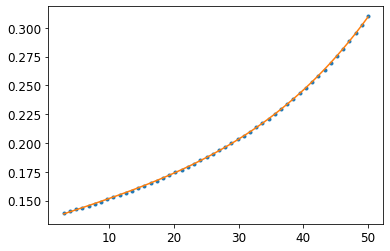

In [18]:
from NODE_fns import NODE_vmap as NN
from jax import grad, vmap, jit, partial, random
key = random.PRNGKey(0)
from jax.experimental import optimizers
import numpy as np
import matplotlib.pyplot as plt
import pickle

# with open('savednet/test_ghent.npy', 'rb') as f:
#     params = pickle.load(f)
    
mu = 0.27812
J = 85.2358
I1 = np.linspace(3,50)
pr = NN(I1-3,params[0]) + params[1]
gt = mu/2*(J/(J-I1+3))

fig, ax = plt.subplots()
ax.plot(I1, gt, '.')
ax.plot(I1, pr, '-')

with open('savednet/test_ghent.npy', 'wb') as f:
    pickle.dump(params, f)